# Rule-Based GA toward XAI

In [ ]:
import math
import random
from random import sample

import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Layer, Concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.initializers import Initializer
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras

from google.colab import drive
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from numpy import loadtxt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from math import log2



In [ ]:
def result(history):
  acc=history.history['val_accuracy']
  loss = history.history['loss']
  print("Accuracy of the Model: {}% \n Error: {}".format(acc[-1]*100, loss[-1]))

  plt.subplot(2, 1, 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.subplot(2, 1, 2)
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, 'y', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  

### Iris Dataset

In [ ]:
#This is a standard machine learning dataset from the UCI Machine Learning repository

df = datasets.load_iris()
X = df.data
y_ = df.target.reshape(-1, 1) # Convert data to a single column
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# sepal length, sepal width, petal length, petal width and species


In [ ]:
def assign_excess(interval, excess):
    ex=set()
    i=0
    while i < excess:
      x=random.randint(0, interval-1)
      if x in ex:
        continue
      else:
        ex.add(x)
        print(x)
        i+=1
    return ex

def intervals(data, interval):
    interval_list=[None]*interval
    sorted_data=np.sort(data)
    length=len(sorted_data)
    slice_range=math.floor(length/interval) # To get a length of each interval
    excess=set()
    if slice_range*interval<length:
      excess=assign_excess(interval, length-slice_range*interval) #Todo: Change this to binary operation

    # print(sorted_data)
    # print("Total Length: {}".format(length))
    # print("Slice Range: {}".format(slice_range))
    i=0
    cnt=0
    while i<length:
      e=0
      if cnt in excess: #Todo: Change this to binary operation
        e+=1
      if cnt==0:
        partition=(sorted_data[i-1+slice_range+e]+sorted_data[i+slice_range+e])/2 # This will be passed to the next beginning of slice
        interval_list[cnt]=("neg_inf", sorted_data[i-1+slice_range+e])
        # print("{} {} = {}".format(sorted_data[i-1+slice_range+e],sorted_data[i+slice_range+e], partition))
      elif i+slice_range+e==length:
        interval_list[cnt]=(partition, "pos_inf")
      else:
        new_partition=(sorted_data[i-1+slice_range+e]+sorted_data[i+slice_range+e])/2 # This will be passed to the next beginning of slice
        interval_list[cnt]=(partition, new_partition)
        partition=new_partition
        # print("{} {} = {}".format(sorted_data[i-1+slice_range+e],sorted_data[i+slice_range+e], new_partition))

      # print("{} - {}".format(interval_list[cnt][0],interval_list[cnt][1]))
      i+=slice_range+e
      cnt+=1
    return interval_list

def generateRuleSets(N, all_intervals, n_class):
  rules=[]
  for n in range(0, N):
    rules.append(generateRule(all_intervals, n_class))
  return rules

def generateRule(all_intervals, n_class):
  rule=[]
  length=len(all_intervals)
  n_intervals=len(all_intervals[0])
  for n in range(0, length):
    rule.append(all_intervals[n][random.randint(0, n_intervals-1)]) # Interval Added
  for p in generateParam(n_class):
    rule.append(p)
  return rule

def generateParam(n_class):
  weight=[]
  for i in range(0, n_class):
    weight.append(random.random())
  # print("Weight before softmax {}".format(weight))
  # print("parameter {}".format(softmax(weight)))
  return softmax(weight)

def generateBundles(n_bundles, n_rules, all_intervals, n_class):
  bundles=[]
  for i in range(n_bundles):
    bundles.append(generateRuleSets(n_rules, all_intervals, n_class))
  return bundles

def check_rule(val, criteria):
  if criteria[0]=="neg_inf":
      # print("Value to check: {} -- Rule: val <= {} ---------- {}".format(val, criteria[1], val<=criteria[1]))
      if val<criteria[1]:
        return 1
  elif criteria[1]=="pos_inf":
      # print("Value to check: {} -- Rule: {} < = val ---------- {}".format(val, criteria[0], criteria[0]< val))
      if criteria[0]<=val:
        return 1
  else:
      if criteria[0]<=val and val<criteria[1]:
        # print("Value to check: {} -- Rule: {} <= val <= {} ---------- {}".format(val, criteria[0], criteria[1], criteria[0]<=val and val<=criteria[1]))
        return 1
  return 0

def isEqualArr(arr1, arr2):
  #Check if two arrays are identical
  if len(arr1)!=len(arr2):
    return False
  else:
    for i, j  in zip(arr1, arr2):
      if i!=j:
        return False
  return True

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# def evaluate_rule(rule, n_class, input, obj): 
#   loss=0
#   # Loop over all the training data
#   for i in range(0, len(input)):
#     # Loop over the rule to examine its fitness
#     pred=predict(rule, n_class, input.iloc[i])
#     # print("Pred {} - Act {}".format(pred, obj[i]))
#     # print(loss)
#     loss+=cross_entropy(pred, obj[i]) # loss increments/Decrements depending on match/unmatch
#     # print(loss)
#   return loss

# def evaluate_bundle(bundle, n_class, input, obj): 
#   loss=0
#   vote 
#   # Loop over all the training data
#   for rule in bundle:
#     loss+=evaluate_rule(rule, n_class, input, obj) 
#   return loss

def cross_entropy(X, y):
  print("X is {} y is {}".format(X, y))
  return -sum([y[i]*log2(X[i]) for i in range(len(X))])

def evolve_bundle(bundles, r_mut, all_intervals, n_class, n_parents, n_children, rule_evolve):
    # Select) randomly multiple sets of rule bundles that predict the class - If none found by the end of "trial", return to 1
    evo_bundles, others=select_parents(bundles, n_parents)
    children=[]
    for i in range(0, n_children):
      # Crossover)
      p1, p2=select(evo_bundles, 2)
      for child_bundle in sample(crossover_bundle(p1, p2, rule_evolve),1):
        # Mutate bundles)
        child_bundle=mutate_bundle(child_bundle, r_mut, all_intervals, n_class)
        children.append(child_bundle)

    # Pick     
    rep_bundles, evo_others=select_parents(evo_bundles, n_children)

    # Concatenate 
    bundles=rep_bundles+evo_others+others
    # print("bundles after: len={} and {}".format(len(bundles), bundles))
    return bundles

def select(obj, n_sample):
  return sample(obj, n_sample)

def select_parents(obj, n_sample):
  evo=[]
  random.shuffle(obj)
  for i in range(0, n_sample):
    evo.append(obj.pop())
  return evo, obj

# mutation operator
def mutate_rule(child_rule, n_class, all_intervals):
  n_intervals=len(all_intervals[0])
  for i in range(0, len(child_rule)-n_class):
    child_rule[i] = all_intervals[i][random.randint(1, n_intervals-1)]
  child_rule[-n_class:] =generateParam(n_class)
  # print("child_rule:{}".format(child_rule[-n_class:]))
  return child_rule

# mutation operator
def mutate_bundle(child_bundle, r_mut, all_intervals, n_class):
  for child_rule in child_bundle:
    if random.random() < r_mut:
      child_rule=mutate_rule(child_rule, n_class, all_intervals)
  return child_bundle

# crossover two parents to create two children bundles
def crossover_bundle(p1,p2, rule_evolve):
	# children are copies of parents by default
  c1, c2 =p1.copy(), p2.copy()
  # select crossover point that is not on the end of the string
  pt = random.randint(1, len(c1)-1)
  # perform crossover
  c1 = p1[:pt] + p2[pt:]
  c2 = p2[:pt] + p1[pt:]
  if rule_evolve:
    c1=crossover_rules(c1) 
    c2=crossover_rules(c2)
  return c1, c2

def crossover_rules(p):
  if len(p)%2==0:
    mid=len(p)//2
    sep=mid
    c1=p[:mid].copy()
    c2=p[sep:].copy()
    c1, c2=crossover(c1, c2)
    return c1+c2
    
  else:
    mid=len(p)//2
    sep=mid+1
    c1=p[:mid].copy()
    c2=p[sep:].copy()
    c3=[p[mid]]
    c1, c2=crossover(c1, c2)
    return c1+c3+c2

def crossover(c1, c2):
  random.shuffle(c1)
  random.shuffle(c2)
  for r1, r2 in zip(c1, c2):
    # select crossover point that is not on the end of the string
    pt = random.randint(1, len(c1)-1)
    # perform crossoverhy
    r1 = r1[:pt] + r2[pt:]
    r2 = r2[:pt] + r1[pt:]
  return c1, c2

def crossover_rules_past(p1,p2):
	# children are copies of parents by default
  c1, c2 =p1.copy(), p2.copy()
  random.shuffle(c1)
  random.shuffle(c2)
  for r1, r2 in zip(c1, c2):
    # select crossover point that is not on the end of the string
    pt = random.randint(1, len(c1)-1)
    # perform crossoverhy
    r1 = r1[:pt] + r2[pt:]
    r2 = r2[:pt] + r1[pt:]
  return c1, c2

def GA(X_train, y_train, n_bundles, n_rules, generations, n_class, r_mut, n_parents, n_children, n_train=30, rule_evolve=False):

  if(n_parents<1):
    n_parents=round(n_parents*n_bundles) # if parent's ratio is set %, it takes concrete # of parents
  
  n_attributes=len(X_train.columns)
  col0=intervals(X_train[0], 10) # Todo: Program it to be dynamic
  col1=intervals(X_train[1], 10)
  col2=intervals(X_train[2], 10)
  col3=intervals(X_train[3], 10)
  all_intervals=[col0, col1, col2, col3]
  
  gen_score={} # Todo delete

  # Generate n bundles with n_rules 
  bundles = generateBundles(n_bundles, n_rules, all_intervals, n_class)
  best_accuracy, best_bundle = eval_bundle(bundles[0], n_class, X_train, y_train), bundles[0]
  for gen in range(generations):
    print("------------Generation {} ------------".format(gen))
    print("")
    # print(bundles)
    accuracies=[]
    l=len(X_train)
    sample_idx=np.random.choice(l, n_train)
    
    for i in range(0, len(bundles)):
      accuracy=eval_bundle(bundles[i], n_class, X_train.iloc[sample_idx,:], y_train[sample_idx])
      accuracies.append(accuracy)
      # Compare new accuracy with current best 
      if accuracy > best_accuracy:
        best_accuracy, best_bundle = accuracy, bundles[i]
        print("New Best {} = {}".format(gen, best_bundle, best_accuracy))

    # Measure fitness of parents each gen 
    input=pd.DataFrame(X_test)
    interim_score=eval_bundle(best_bundle, n_class, input, y_test)
    print("Interim Accuracy {}".format(interim_score))
    gen_score[gen]=interim_score

    #Generate new generations
    bundles=evolve_bundle(bundles, r_mut, all_intervals, n_class, n_parents, n_children, rule_evolve)

  print("Final Rule {} -- Accuracy: {}".format(best_bundle, best_accuracy))
  plt.figure(figsize=(5,5))
  plt.plot(list(gen_score.keys()), list(gen_score.values()))
  plt.xticks(np.arange(0, generations, step=10))
  plt.yticks(np.arange(0, 1.2, step=0.2))
  condition="{} bundles with {} rules each, {} parents to generate {} children".format(n_bundles, n_rules, n_parents, n_children)
  plt.title(condition, pad=20)
  accuracy=eval_bundle(best_bundle, n_class, input, y_test)
  result="The accuracy of the final Model {}".format(accuracy)
  plt.text((generations-1)/2, accuracy*1.1, result)
  plt.show()
  return best_bundle #, best_accuracy

Streaming output truncated to the last 5000 lines.
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
[0, 0, 0] vs [0. 0. 1.] --- False
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
Vote before:[0, 0, 0]
Vote After [0, 0, 0]
[0, 0, 0] vs [1. 0. 0.] --- False
Vote before:[0, 0, 0]

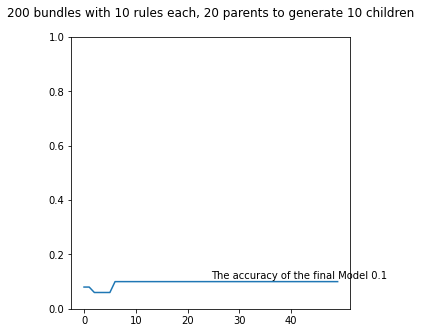

In [ ]:
def predict(rule, n_class, X_data):
  pred=[0,0,0]
  val=0
  # print("Input Data:{}".format(X_data))
  for k in range(0, len(X_data)):
    val+=check_rule(X_data[k], rule[k])
  if val==3:
    pred=rule[-n_class:]
    # print("Increment {}".format(convert_predictor(pred)))
  return convert_predictor(pred)

def convert_predictor(res):
  ans=[0, 0, 0]
  # print("Original output {}".format(res))
  new_list=sorted(res, key=None, reverse=True)  
  # print("Sorted List {}".format(new_list))
  first=new_list[0]
  second=new_list[1]
  if first!=second:
    # idx=np.where(res==first)[0][0]
    idx=res.index(first)
    ans[idx]=1
  return ans

def vote(bundle, n_class, X_data):
  vote=[0,0,0]
  for rule in bundle:
    print("Vote before:{}".format(vote))
    pred=predict(rule, n_class, X_data)
    vote=sum_pred(vote, pred)
    print("Vote After {}".format(vote))
  return vote

def sum_pred(list1, list2):
  sum_list=[]
  for (item1, item2) in zip(list1, list2):
    sum_list.append(item1+item2)
  return sum_list

def eval_bundle(bundle, n_class, input, obj):
  score=0
  # Loop over all the training data
  for i in range(0, len(input)):
    # Loop over the rule to examine its fitness
    # print("Bundle {} input {}".format(bundle, input.iloc[i]))
    v=convert_predictor(vote(bundle, n_class, input.iloc[i]))
    print("{} vs {} --- {}".format(v, obj[i], isEqualArr(v, obj[i])))
    if isEqualArr(v, obj[i]):
      score+=1
  return score/len(obj) # Return the % of accuracy for the target class

df_X_train=pd.DataFrame(X_train)
n_bundles=200
n_rules=10
generations=50
r_mut=0.03
n_class=3
n_train=20
n_parents=20
n_children=10
input=pd.DataFrame(X_test)
obj=y_test
rule_evolve=True

model=GA(df_X_train, y_train, n_bundles, n_rules, generations, n_class, r_mut, n_parents, n_children, n_train, rule_evolve)
# my_series.value_counts()
# len(counts)


# for n_bundles in [150, 200]:
#   for n_rules in [25, 50]:
#       model=GA(df_X_train, y_train, n_bundles, n_rules, generations, n_class, r_mut, n_parents, n_children, n_train, rule_evolve)



#### NN Model

Accuracy of the Model: 100.0% 
 Error: 0.08392251282930374


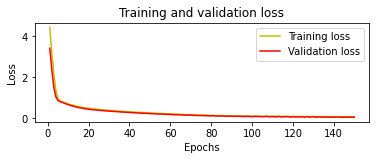

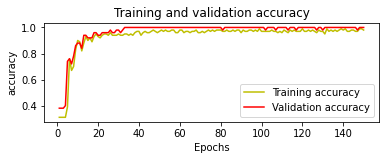

In [ ]:

# define the keras model
model = Sequential()
model.add(Dense(10, input_shape=(4,), activation='selu', name="L1"))
model.add(Dense(10, activation='selu', name="L2"))
model.add(Dense(3, activation='softmax', name="Output"))

# compile the keras model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the keras model on the dataset
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=10, verbose=0)
result(history)

# Under Construction

In [ ]:
# Table

https://stackoverflow.com/questions/56041337/how-to-draw-a-beautiful-colorful-table-with-pandas-or-other-package-in-python